# Data    Analysis   Challenge

# Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
%matplotlib inline
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from pylab import plot, show, text
import datetime
import matplotlib.dates as mdates
import pylab

In [3]:
# load as Pandas dataframe
df_logins = pd.read_json('logins.json')
df_logins.index = pd.to_datetime(df_logins.login_time, unit='m')
df_freq = df_logins.groupby(pd.Grouper(freq='15Min')).agg(['count']).rename(columns=dict(count='counts'))
df_freq.columns = df_freq.columns.droplevel(0)
df_freq = df_freq.reset_index(drop=False)

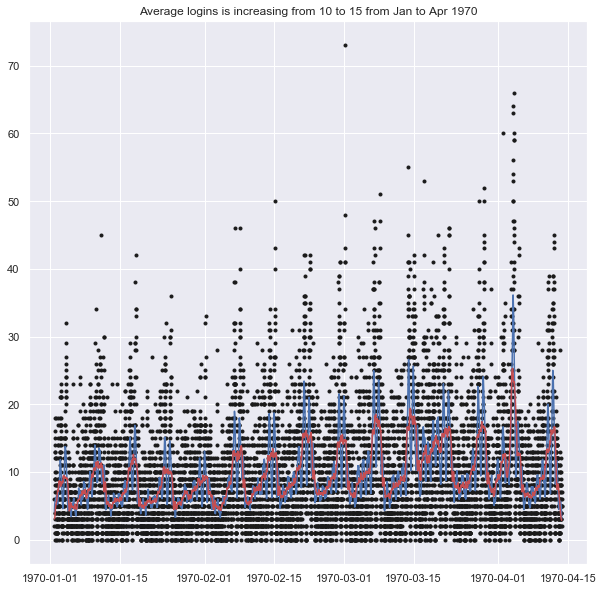

In [6]:
# do scatterplot and moving window average
plt.figure(figsize=(10,10))
def window_lag(size):
    return np.ones(size)/float(size)

# assign data
timepart = df_freq.login_time
height = df_freq.counts
plot(timepart,height,'k.')
plot(timepart,np.convolve(height,window_lag(50),'same'),'b')
plot(timepart,np.convolve(height,window_lag(100),'same'),'r')
pylab.title('Average logins is increasing from 10 to 15 from Jan to Apr 1970')
show()

C:\Users\17138\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


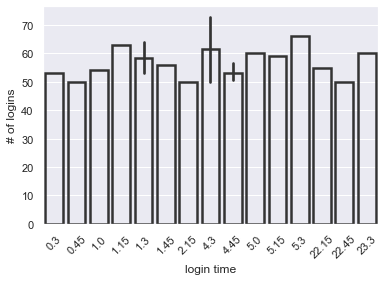

In [7]:
#sort data by counts in descending order
df_sorted = df_freq['counts'].sort_values(ascending=False)

#get only those times with 50 or more logins
df = df_freq[df_freq.loc[df_sorted.index]['counts'] >= 50].reset_index(drop=True)
df['_time_']=df['login_time'].dt.strftime('%H:%M:%S') 
df = df.sort_values(by='_time_', ascending=True)

#format time into 2 decimal places like 4:30 -> 4.30
df['_time_']=df['_time_'].apply(lambda x: float(x.replace(':',''))/10000)

#draw bar chart 
ax=sns.barplot(x="_time_", y="counts", data=df, linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
ax.set(ylabel='# of logins', xlabel='login time')
plt.xticks(rotation=45)

#show chart
plt.show()

# Analysis:

1. Login peak hours is from 22:00 to 5:00
2. Max peak hours is from 4:00 to 6:00 AM with 50 to 73 logins
3. Based on moving average window of past 100 logins, there is an increase on the login from 10 to 15 logins from Jan to Apr 1970

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
    Measure the gross income of taxi and logistics transportation companies for both cities before and after implementing reimbursement of toll costs
    b. what statistical test(s) you will conduct to verify the significance of the observation
    To test the effectiveness of free toll fee, use t-test for paired observations. It is paired observation because the same taxi/transportation company will be compared before and after implementing toll free
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
    The null hypothesis is the gross income of taxi and transportation companies for Gotham city is the same for free toll and for non-free toll costs The alternative hypothes is the gross income of taxi and transportation companies for Gotham city with free toll is greater than for non-free toll costs
    Another hypotheses are as follow: The null hypothesis is the gross income of taxi and transportation companies for Metropolis city is the same for free toll and for non-free toll costs The alternative hypothes is the gross income of taxi and transportation companies for Metropolis city with free toll is greater than for non-free toll costs
    Iterpret the results based on t-statistic if it is significant at 5% or 1%. If the null hypothesis is/are rejected then there is an evidence to support that free toll fee is beneficial to one or both cities. However, the limitations/assumptions are 1) within the duration of the experiment, both cities are not affected by factors due to seasonality or peak season. 2) The traffic conditions for both cities before and after the experiment are the same.

In [8]:
import json
#read and load json file
with open('ultimate_data_challenge.json') as f:
    data = json.load(f) 
#convert to dataframe
df_usage = pd.DataFrame(data)
df_backup = pd.DataFrame(data)

#Winterfell        |Astapor  |King's Landing    
#df_usage = df_usage[df_usage.city == 'King\'s Landing']

#convert string to datetime
df_usage['last_trip_date'] = pd.to_datetime(df_usage['last_trip_date'])
df_usage['signup_date']    = pd.to_datetime(df_usage['signup_date'])

#calculate number of days that user is active
df_usage['num_of_days_active'] = df_usage['last_trip_date'] - df_usage['signup_date'] 

#assign 1 if active, 0 if not active for past
df_usage['active_user'] = df_usage['num_of_days_active'].apply(lambda x: int(x >= pd.Timedelta('150 days')))

#assign 1 if iPhone, 0 if not
df_usage['phone'] = df_usage['phone'].apply(lambda x: int(x == 'iPhone'))

#assign 1 if True, 0 if False
df_usage['ultimate_black_user'] = df_usage['ultimate_black_user'].apply(lambda x: int(x == True))

#drop columns with NaN 
#df_usage=df_usage.fillna(0)
#df_usage=df_usage.fillna(df_usage.mean())
df_usage=df_usage.dropna(0)

In [9]:
df_usage.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,num_of_days_active,active_user
count,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744,41744.000000
mean,2.611393,4.601801,1.073697,0.703143,8.884695,0.385612,61.304437,5.465312,4.776648,98 days 01:11:01.632809,0.282460
std,4.060121,0.616079,0.198681,0.456878,18.309042,0.486745,34.799944,5.149810,0.404109,61 days 05:30:51.610445,0.450201
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0 days 00:00:00,0.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,0.000000,37.500000,2.420000,4.700000,38 days 00:00:00,0.000000
50%,1.000000,4.900000,1.000000,1.000000,0.000000,0.000000,66.700000,3.790000,5.000000,118 days 00:00:00,0.000000
75%,3.000000,5.000000,1.070000,1.000000,11.100000,1.000000,100.000000,6.490000,5.000000,152 days 00:00:00,1.000000
max,125.000000,5.000000,8.000000,1.000000,100.000000,1.000000,100.000000,79.690000,5.000000,181 days 00:00:00,1.000000


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#construct the dataset X, y
X = df_usage[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 
'phone', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']]
y = (df_usage.active_user == 1)

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X.values, y.values, test_size=0.20, random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print("Accuracy score: ", accuracy_score(clf.predict(Xtestlr), ytestlr))

# Print importance of each features
clf.fit(Xlr / np.std(Xlr, 0), ylr)
print("Regression coefficients: ", clf.coef_)
print("Column names: ", (X.columns.values))

Accuracy score:  0.728829799976045
Regression coefficients:  [[-0.19257451 -0.04507601  0.00301157 -0.05549293  0.44953598  0.11112835
   0.3609592   0.34239547  0.00328261]]
Column names:  ['avg_dist' 'avg_rating_by_driver' 'avg_rating_of_driver' 'avg_surge'
 'phone' 'surge_pct' 'trips_in_first_30_days' 'ultimate_black_user'
 'weekday_pct']


C:\Users\17138\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
###Data description
    # city: city this user signed up in
    # phone: primary device for this user
    # signup_date: date of account registration; in the form ‘YYYY MM DD’
    #last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
    # avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    # avg_rating_by_driver: the rider’s average rating over all of their trips
    # avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    # surge_pct: the percent of trips taken with surge multiplier > 1
    # avg_surge: The average surge multiplier over all of this user’s trips
    # trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
    # ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
    # weekday_pct: the percent of the user’s trips occurring during a weekday

# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
About 83% of the dataset were retained after removing records with NaN value.
Data cleaning: I would check if all columns have values within the specified range. If percentage, then max is 100; if number of days in month, then max is 31.
Data formatting: Convert date strings format into datetime, categorical data into integer (like Phone: android is 0 and iphone is 1) and then calculate the number of days from signup date to last active date to determine if user is active for the past 6 months (>=150 days).
EDA: Mostly bar chart for the ratings and averages and pie charts for categorical data like phone and cities
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?Include any key indicators of model performance.
I used LogisticRegression for algorithm since it is categorizing the users into Active (1) or inactive (0). I used accuracy score function from sklearn. Key indicators are phone (Android/iPhone), ratings of the driver, number of trips for the first 30days.
Alternative models instead of logistics regression: Random forest and gradient boosting machine (gbm)
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

Recommendations:
1) increase marketing on company apps (if any) for iPhone users; it shows that iPhone users are more active than android users
2) Monitor bad behaviors of drivers based on customer ratings and give incentives to drivers with consistent high ratings
3) First 30days of the customer is critical on customer retention. Give discounts or promotions during the first 30days of sign-up.